In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.python.client import device_lib

In [2]:
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [3]:
labels_train = pd.read_csv('faces/labels_train.csv')
labels_valid = pd.read_csv('faces/labels_valid.csv')
labels_test = pd.read_csv('faces/labels_test.csv')

In [4]:
datagen = ImageDataGenerator(rescale=1/255.0)

In [5]:
test_datagen = datagen.flow_from_dataframe(dataframe=labels_test,
                                           directory='faces/test',
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(224,224),
                                           batch_size=16,
                                           class_mode='raw',
                                           seed=12345)
features_test, target_test = next(test_datagen)

Found 1978 validated image filenames.


In [6]:
valid_datagen = datagen.flow_from_dataframe(dataframe=labels_valid,
                                            directory='faces/valid',
                                            x_col='file_name',
                                            y_col='real_age',
                                            target_size=(224,224),
                                            batch_size=16,
                                            class_mode='raw',
                                            seed=12345)

Found 1500 validated image filenames.


In [7]:
train_datagen = datagen.flow_from_dataframe(dataframe=labels_train,
                                            directory='faces/train',
                                            x_col='file_name',
                                            y_col='real_age',
                                            target_size=(224,224),
                                            batch_size=16,
                                            class_mode='raw',
                                            seed=12345)

Found 4113 validated image filenames.


In [8]:
labels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4113 entries, 0 to 4112
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  4113 non-null   object
 1   real_age   4113 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 64.4+ KB


<AxesSubplot:>

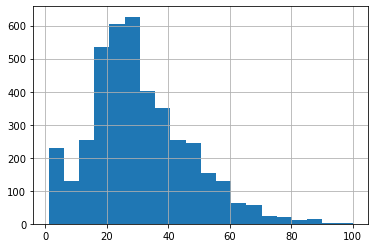

In [9]:
labels_train['real_age'].hist(bins=20)

Средний возраст в районе 30 лет

In [10]:
features_train, target_train = next(train_datagen)

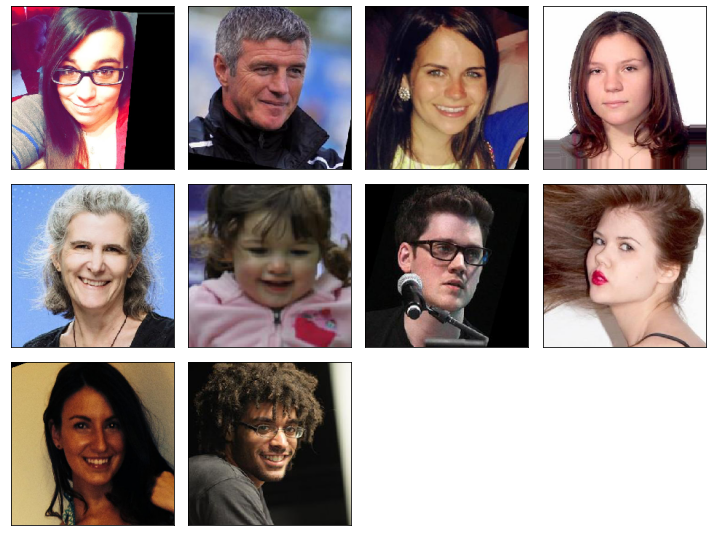

In [11]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Пример фотографий

In [12]:
labels_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1500 non-null   object
 1   real_age   1500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.6+ KB


<AxesSubplot:>

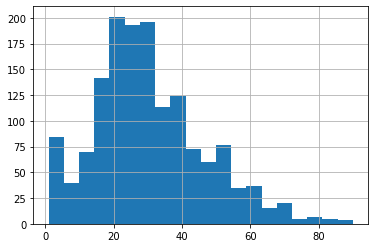

In [13]:
labels_valid['real_age'].hist(bins=20)

In [14]:
features_valid, target_valid = next(valid_datagen)

In [15]:
layer = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet', 
                    include_top=False)
model = Sequential()
model.add(layer)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu')) 
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

In [16]:
model.fit(train_datagen,
          validation_data=valid_datagen,
          epochs=5,
          verbose=1,
          shuffle=True,
          batch_size=16)

Epoch 1/5
258/258 [==============================] - 7621s 30s/step - loss: 206.4824 - mae: 10.5079 - val_loss: 664.9829 - val_mae: 21.0688
Epoch 2/5
258/258 [==============================] - 7454s 29s/step - loss: 67.6342 - mae: 6.2833 - val_loss: 379.7825 - val_mae: 14.7062
Epoch 3/5
258/258 [==============================] - 8845s 34s/step - loss: 39.4102 - mae: 4.8419 - val_loss: 176.1324 - val_mae: 9.8505
Epoch 4/5
258/258 [==============================] - 5080s 20s/step - loss: 29.0202 - mae: 4.1746 - val_loss: 146.6749 - val_mae: 9.1249
Epoch 5/5
258/258 [==============================] - 4463s 17s/step - loss: 21.7193 - mae: 3.5891 - val_loss: 103.9332 - val_mae: 8.0427


In [17]:
predictions = model.predict(features_test, batch_size=16, verbose=1)

1/1 [==============================] - 0s 0s/step


In [18]:
mean_absolute_error(target_test, predictions)

7.425690442323685